Training data generated and saved to training_data.xlsx.
Best SQ Policy: s=6, Q=70, Cost=111220.0
Best RS Policy: R=4, S=30, Cost=56187.7999999997
Episode 1/40, Total Reward: -18.5
Episode 1/40, Total Reward: -19.5
Episode 1/40, Total Reward: -33.6
Episode 1/40, Total Reward: -54.3
Episode 1/40, Total Reward: -67.7
Episode 1/40, Total Reward: -85.6
Episode 1/40, Total Reward: -101.39999999999999
Episode 1/40, Total Reward: -114.89999999999999
Episode 1/40, Total Reward: -126.99999999999999
Episode 1/40, Total Reward: -138.39999999999998
Episode 1/40, Total Reward: -138.39999999999998
Episode 1/40, Total Reward: -167.79999999999998
Episode 1/40, Total Reward: -182.39999999999998
Episode 1/40, Total Reward: -199.09999999999997
Episode 1/40, Total Reward: -219.19999999999996
Episode 1/40, Total Reward: -239.89999999999995
Episode 1/40, Total Reward: -241.09999999999994
Episode 1/40, Total Reward: -255.19999999999993
Episode 1/40, Total Reward: -272.3999999999999
Episode 1/40, Total Reward

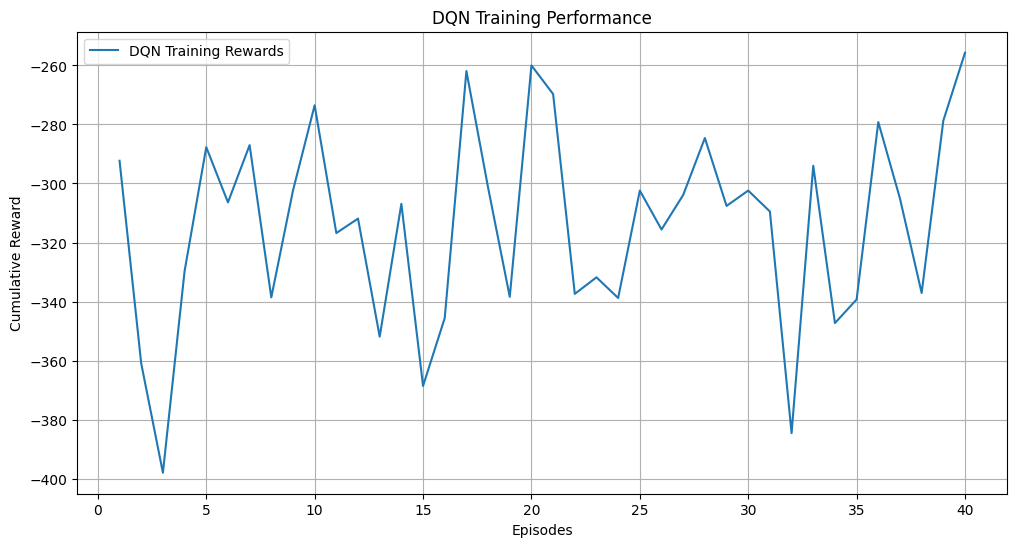

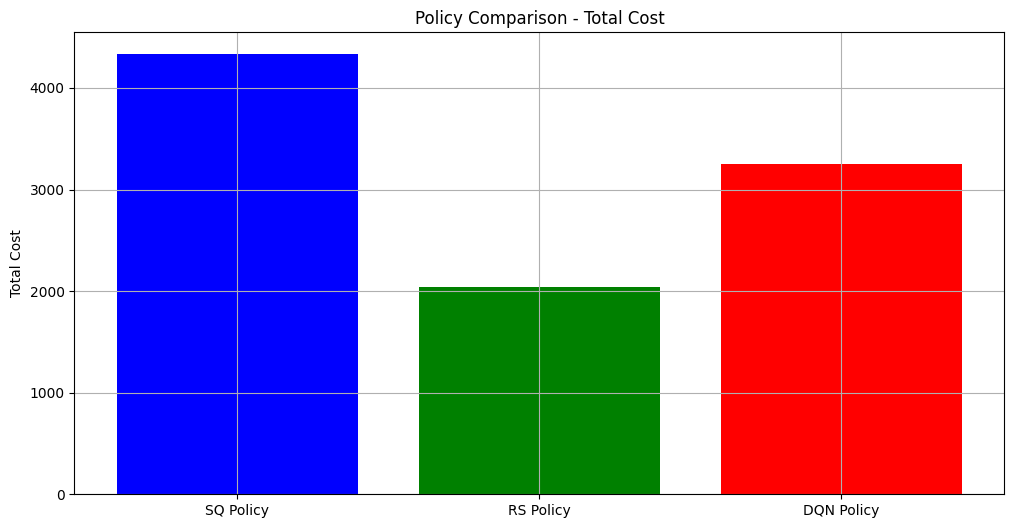

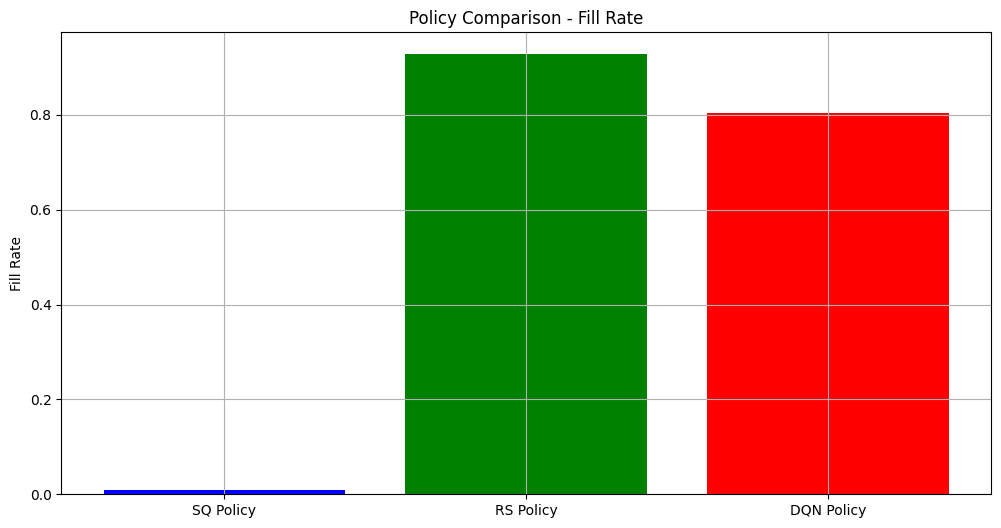

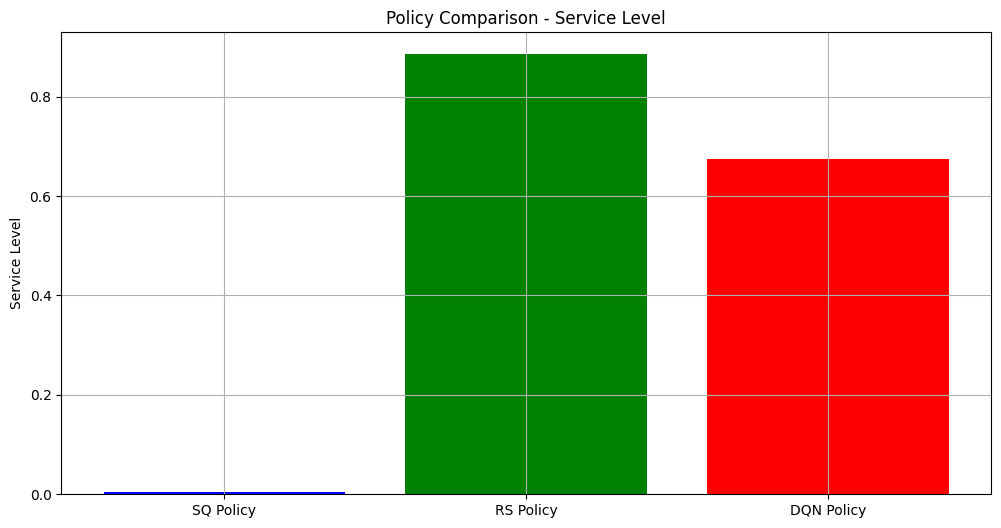

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import pandas as pd

# Define common configurations
CONFIG = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'loss_sales_penalty': 5,
    'demand_mean': 5,
    'demand_std': 2,
    'max_inventory': 60,
    'fixed_lead_time': 2
}

# Define demand generator
class HalfNormalGenerator:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def next(self):
        return abs(np.random.normal(self.mean, self.std))

# Define common environment class
class SupplyChainEnvironment:
    def __init__(self, config):
        self.config = config
        self.inventory = np.random.randint(10, 20)
        self.demand_generator = HalfNormalGenerator(config['demand_mean'], config['demand_std'])
        self.fixed_lead_time = config['fixed_lead_time']
        self.reset()

    def reset(self):
        self.inventory = np.random.randint(10, 20)
        self.orders = []
        self.total_cost = 0
        self.total_filled_demand = 0
        self.total_demand = 0
        return self.inventory

    def step(self, order_quantity):
        # Process demand
        demand = int(self.demand_generator.next())
        self.total_demand += demand
        filled_demand = min(demand, self.inventory)
        self.inventory -= filled_demand
        self.total_filled_demand += filled_demand

        # Process order
        if order_quantity > 0:
            self.inventory += order_quantity
            self.orders.append(order_quantity)
        else:
            self.orders.append(0)

        # Calculate costs
        fixed_cost = self.config['fixed_transaction_cost'] if order_quantity > 0 else 0
        variable_cost = self.config['variable_transaction_cost'] * order_quantity
        holding_cost = self.config['holding_cost'] * self.inventory
        lost_sales_cost = self.config['loss_sales_penalty'] * (demand - filled_demand)
        total_cost = fixed_cost + variable_cost + holding_cost + lost_sales_cost
        self.total_cost += total_cost

        # Return new state, reward
        reward = -(total_cost)
        return self.inventory, reward

# Define SQ Policy
class sQInventoryPolicy:
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q

    def order(self, inventory):
        if inventory <= self.s:
            return self.Q
        return 0

# Define RS Policy
class RSInventoryPolicy:
    def __init__(self, R, S):
        self.R = R
        self.S = S

    def order(self, inventory, timestep):
        if timestep % self.R == 0 and inventory <= self.S:
            return self.S - inventory
        return 0

# Define DQN Policy
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []
        self.batch_size = 64
        self.model = self._build_model()

    def _build_model(self):
        # Changed to use Input layer to avoid Keras warnings
        model = Sequential([
            Input(shape=(self.state_size,)),  # Explicit Input layer
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample indices instead of sampling memory directly
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        minibatch = [self.memory[i] for i in indices]  # Create a minibatch from sampled indices

        states, targets = [], []
        for state, action, reward, next_state in minibatch:
            # Compute target for Q-learning update
            target = reward + self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)[0]
            target_f[action] = target  # Update the Q-value for the action taken

            states.append(state)  # Append the state
            targets.append(target_f)  # Append the updated Q-values

        # Fit the model with the updated states and targets
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

# Generate and save training data
def generate_data(episodes, timesteps, config):
    env = SupplyChainEnvironment(config)
    data = []
    for _ in range(episodes):
        state = env.reset()
        for _ in range(timesteps):
            demand = env.demand_generator.next()
            data.append([state, demand])
    df = pd.DataFrame(data, columns=['State', 'Demand'])
    df.to_excel("training_data.xlsx", index=False)
    return df

# Train and evaluate SQ policy
def train_evaluate_sq_policy(training_data, config):
    best_s, best_Q, best_cost = None, None, float('inf')
    env = SupplyChainEnvironment(config)
    for s in range(1, 20, 5):
        for Q in range(10, 100, 10):
            policy = sQInventoryPolicy(s, Q)
            total_cost = 0
            for _, row in training_data.iterrows():
                state, demand = row['State'], row['Demand']
                order = policy.order(state)
                _, reward = env.step(order)
                total_cost -= reward
            if total_cost < best_cost:
                best_s, best_Q, best_cost = s, Q, total_cost
    return best_s, best_Q, best_cost

# Train and evaluate RS policy
def train_evaluate_rs_policy(training_data, config, fixed_R):
    best_S, best_cost = None, float('inf')
    env = SupplyChainEnvironment(config)
    max_S = config['max_inventory']
    for S in range(10, max_S + 1, 10):  # Fixed indentation issue
        policy = RSInventoryPolicy(fixed_R, S)
        total_cost = 0
        for timestep, row in enumerate(training_data.itertuples()):
            state, demand = row.State, row.Demand
            order = policy.order(state, timestep)
            _, reward = env.step(order)
            total_cost -= reward
        if total_cost < best_cost:
            best_S, best_cost = S, total_cost
    return fixed_R, best_S, best_cost

# Train and evaluate DQN policy
def train_evaluate_dqn_policy(training_data, config):
    env = SupplyChainEnvironment(config)
    agent = DQNAgent(state_size=1, action_size=10)  # Assuming 10 possible order quantities
    episodes = 40  # Reduced from 100 to speed up training
    timesteps = 20  # Reduced from 50 to speed up training
    rewards_per_episode = []
    for episode in range(episodes):
        state = env.reset()
        state = np.array([state])
        total_reward = 0
        for _ in range(timesteps):
            action = agent.act(state)
            next_state, reward = env.step(action)
            next_state = np.array([next_state])
            agent.remember(state, action, reward, next_state)
            state = next_state
            agent.replay()
            total_reward += reward
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")  # Added progress print statement
        rewards_per_episode.append(total_reward)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    return agent, rewards_per_episode

# Generate test data and evaluate all policies
def evaluate_policies_on_test_data(agent, best_s, best_Q, fixed_R, best_S, config):
    test_data = generate_data(10, 20, config)  # 10 episodes, 50 timesteps each
    env = SupplyChainEnvironment(config)

    # Evaluate SQ Policy
    sq_policy = sQInventoryPolicy(best_s, best_Q)
    sq_total_cost = 0
    sq_fill_rate = 0
    sq_service_level = 0
    for _, row in test_data.iterrows():
        state, demand = row['State'], row['Demand']
        order = sq_policy.order(state)
        _, reward = env.step(order)
        sq_total_cost -= reward
        sq_fill_rate += min(demand, env.inventory) / demand
        sq_service_level += (env.inventory >= demand)

    # Evaluate RS Policy
    rs_policy = RSInventoryPolicy(fixed_R, best_S)
    rs_total_cost = 0
    rs_fill_rate = 0
    rs_service_level = 0
    for timestep, row in enumerate(test_data.itertuples()):
        state, demand = row.State, row.Demand
        order = rs_policy.order(state, timestep)
        _, reward = env.step(order)
        rs_total_cost -= reward
        rs_fill_rate += min(demand, env.inventory) / demand
        rs_service_level += (env.inventory >= demand)

    # Evaluate DQN Policy
    dqn_total_cost = 0
    dqn_fill_rate = 0
    dqn_service_level = 0
    dqn_rewards = []
    for _, row in test_data.iterrows():
        state = np.array([row['State']])
        action = agent.act(state)
        _, reward = env.step(action)
        dqn_total_cost -= reward
        dqn_fill_rate += min(row['Demand'], env.inventory) / row['Demand']
        dqn_service_level += (env.inventory >= row['Demand'])
        dqn_rewards.append(reward)

    return (
        sq_total_cost, rs_total_cost, dqn_total_cost,
        sq_fill_rate / len(test_data), rs_fill_rate / len(test_data), dqn_fill_rate / len(test_data),
        sq_service_level / len(test_data), rs_service_level / len(test_data), dqn_service_level / len(test_data),
        dqn_rewards
    )

# Plot performance metrics
def plot_performance_metrics(dqn_rewards, rewards_per_episode, sq_cost, rs_cost, dqn_cost, sq_fill_rate, rs_fill_rate, dqn_fill_rate, sq_service_level, rs_service_level, dqn_service_level):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(rewards_per_episode) + 1), rewards_per_episode, label="DQN Training Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.title("DQN Training Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(["SQ Policy", "RS Policy", "DQN Policy"], [sq_cost, rs_cost, dqn_cost], color=["blue", "green", "red"])
    plt.ylabel("Total Cost")
    plt.title("Policy Comparison - Total Cost")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(["SQ Policy", "RS Policy", "DQN Policy"], [sq_fill_rate, rs_fill_rate, dqn_fill_rate], color=["blue", "green", "red"])
    plt.ylabel("Fill Rate")
    plt.title("Policy Comparison - Fill Rate")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(["SQ Policy", "RS Policy", "DQN Policy"], [sq_service_level, rs_service_level, dqn_service_level], color=["blue", "green", "red"])
    plt.ylabel("Service Level")
    plt.title("Policy Comparison - Service Level")
    plt.grid(True)
    plt.show()

# Main Execution
if __name__ == "__main__":
    training_data = generate_data(100, 50, CONFIG)
    print("Training data generated and saved to training_data.xlsx.")

    # Train and evaluate SQ policy
    best_s, best_Q, best_cost_sq = train_evaluate_sq_policy(training_data, CONFIG)
    print(f"Best SQ Policy: s={best_s}, Q={best_Q}, Cost={best_cost_sq}")

    # Train and evaluate RS policy
    fixed_R = 4  # Suggested value for R
    best_R, best_S, best_cost_rs = train_evaluate_rs_policy(training_data, CONFIG, fixed_R)
    print(f"Best RS Policy: R={fixed_R}, S={best_S}, Cost={best_cost_rs}")

    # Train and evaluate DQN policy
    dqn_agent, rewards_per_episode = train_evaluate_dqn_policy(training_data, CONFIG)
    print("DQN Policy trained.")

    # Evaluate all policies on test data
    (
        sq_cost, rs_cost, dqn_cost,
        sq_fill_rate, rs_fill_rate, dqn_fill_rate,
        sq_service_level, rs_service_level, dqn_service_level,
        dqn_rewards
    ) = evaluate_policies_on_test_data(dqn_agent, best_s, best_Q, fixed_R, best_S, CONFIG)

    print(f"Test Data Costs - SQ: {sq_cost}, RS: {rs_cost}, DQN: {dqn_cost}")
    print(f"Fill Rates - SQ: {sq_fill_rate}, RS: {rs_fill_rate}, DQN: {dqn_fill_rate}")
    print(f"Service Levels - SQ: {sq_service_level}, RS: {rs_service_level}, DQN: {dqn_service_level}")

    # Plot performance metrics
    plot_performance_metrics(
        dqn_rewards, rewards_per_episode, sq_cost, rs_cost, dqn_cost,
        sq_fill_rate, rs_fill_rate, dqn_fill_rate,
        sq_service_level, rs_service_level, dqn_service_level
    )